# Tutorial: set campaign details

In this tutorial we give some suggestions on how to help clients setting up a campaign. We will consider the case when the campaign performance is verified measuring the number of occurrences of an events (e.g. daily visits to a website, or enquiries), rather than conversion rates.

The task is closely related to the topic of power analysis, and requires exploring the right compromise between:
- **Noise to signal ratio**. This is often a given, and it depends on the quantity we'ds like to measure in our test (e.g. sessions, enquiries). Noise, here feres to the volatility  (standard deviation) of the KPI we'd like to measure, while signal would be the its trend or mean value. In general, when noise is large, detecting a change in the KPI will be harder. For example, assume you want to detect an uplift in daily sessions of 20%. This is going to be easier if the standard deviation of daily sessions is small (e.g. 5% of mean) rather than large (e.g. 40% of mean). The higher the noise to signal ratio, the longer we'll need to run the campaign for and the lower is going to be our power. 
- **(Minimum) detectable effect**. This is the effect that we would like to capture in our test. For example, we would like to capture uplifts of 5% or more. 
- **Campaign lenght (number of observations)** The longer we run a campaign, the easier will be to detect an impact. Obviously, we want to minimise the campaign lenght so as to reduce the risk for our clients and get an answer (was the marketing campaign successful) as early as possible.
- **Power**. This is the probability of not making a Type II error, i.e. the probability of making a correct decision (to reject the null hypothesis) when the null hypothesis is actully false. In a typical scenario the null hypothesis is "The marketing campaign has had no impact on sessions/enquiries/sales", hence one can interpret the power as the probability of detecting a statistically significant impact - when the marketing activities actually had one.
- **Confidence level**. This is the probability of not making a Type I error, i.e. of confirming the null hypothesis when this is true. In a typical scenario this means confirming that the campaign had no impact - if it truly did not have one.

Below find some (useful) references on the topic:
- https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/
- https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

In [1]:
%load_ext autoreload
%autoreload 2

# set-up
import sys, os 
from dotenv import load_dotenv
load_dotenv("../.env")
if os.environ.get("SRC_FOLDER") is None:
    print("Please add path to causalinf library. See README.md.")
sys.path.append(os.environ.get("SRC_FOLDER"))

In [2]:
import pandas as pd 
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt 

import statsmodels.api as sm
import causalinf.stats

# Parameters Utils
random_factor = 9374

# Plotting
fmt_null = {"color": '#1f77b4'}
fmt_alter = {"color": '#ff7f0e'}
fmt_ci = {"alpha": .3, "lw": 0}
fmt_line = {"alpha": .7, "lw": 3}

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Study case

We will design a test for a marketing campaign set to run in Houston and looking at session volume. 

To start with, we read the daily sessions registered in Houston in a period before the campaign start. Note, however, that the only info required for the following analyses are mean and standard deviation of the daily sessions in Houston - so you can skip this section and simply hardcode these info in the next section.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


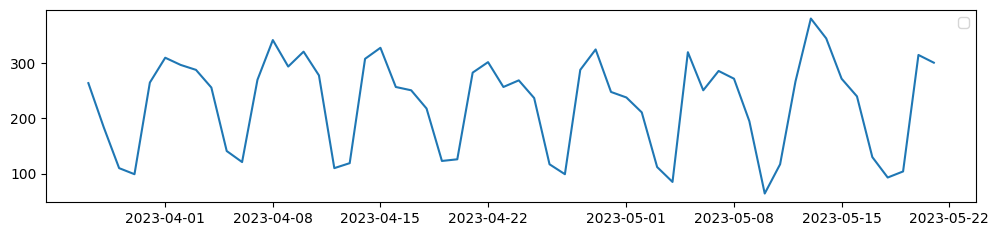

In [3]:
df = pd.read_csv(os.path.join(os.environ.get("SRC_FOLDER"), "tests/fixtures/ga-visits-usa-cities.csv"))
df = causalinf.libs.pd_tools.format_dataframe( df, columns_datetime = ["period_start_date"])
df_pre = df[df["test_active"]==1]
del df

df_pre.head(3)
# Define treated and control units
treated_unit = "Houston"

fig = plt.figure(figsize=(12.,2.5))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
ax.plot(df_pre.period_start_date,df_pre[treated_unit])
ax.legend()
plt.show()

## Hypotheses

- $H_0$: the campaign has no impact on sessions. Namely, there is no significant chance in daily sessions.

- $H_a$: the campaign has an impact on daily sessions. We can fine tune this using the `alternative parameter` below.

## Parameters

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

In order to define the campaign, we'll need:

A. Mean and standard deviation of the treated unit. These represent the mean and std under the null hypothesis - the campaign has no impact on sessions.

B. An `alternative` which will describe whether we want to check that the alternative hypothesis is `larger`, `smaller`. or any of the two (`two_sided`) 

C. Three out of the four parameters below (the 4-th will depend on the others):

- `confidence_level`: tipically `0.95` or `0.90`. This is the probability of detecting a True Negative - i.e. to validate the null hypothesis should it be true. 

- `delta_percent`. This is the effect that we would like to detect, expressed in percentage.

- `power`. The probability of detecting a True Positive - i.e. to detect that the campaign had an impact if it truly had one.

- `n_weeks`. Number of weeks we will run the campaign for. This number is linked to the number of observations. 

You can explore these using the  `causalinf.ab.t_test.get_test_design_summary` function. This function takes in input the arguments (A), (B) and 3 out of 4 arguments from (C) and computes the missing one.

In [4]:
causalinf.ab.t_test.get_test_design_summary?

Signature:
causalinf.ab.t_test.get_test_design_summary(
    mean_null_hp: float,
    std_null_hp: float,
    alternative: str = 'two-sided',
    **kwargs,
)
Docstring:
Convenience wrapper for the `design_test` function. It allows designing a t-test (i.e.
aiming at comparing a change in mean value). The function accepts in input two compulsory arguments 
(`mean_null_hp` and `std_null_hp`), and 3 out of 4 of the following key-word arguments: `n_obs`,
`difference_percent`, `power` and `alpha`. The function will compute the 4-th, unknown,
quantity.

Args:
    mean_null_hp (float): mean under the null hypothesis. This is the mean of the reference sample, 
        and our baseline before the test - e.g. daily number of visits to a website before a
        marketing activity is launched.
    std_null_hp (float): standard deviation under the null hypothesis - e.g. std of saily visits to
        website before marketing activity.
    difference_percent (float): effect that we aim to detect. Thi

## 1. How long should the campaign run for?

If we have clear ideas about the (minimum) effect we want to measure, confidence level and power, then we can determine the minimum campaign length with a power analysis using `causalinf.ab.t_test.get_test_design_summary`.

In [5]:
# INPUT: You can hardcode these.
mean_treated_unit = df_pre[treated_unit].mean()
std_treated_unit = df_pre[treated_unit].std()
# PARAMETERS
confidence_level = 0.9
alternative = "two-sided"
difference_percent = 15.0
power = 0.8

# Power analysis
test_details = causalinf.ab.t_test.get_test_design_summary( 
    mean_treated_unit, std_treated_unit, alternative=alternative, 
     alpha=1.-confidence_level, difference_percent=difference_percent,
    power=power, 
)
n_weeks = test_details["n_obs"]/7
print(f"The test should run for at least {n_weeks:.1f} weeks. "
      f"With this setting we'd be able to detect a change of {difference_percent}% (positive or negative) "  
      f"with a {100.*power:.0f}% probability (power) and confidence level of {100.*confidence_level:.0f}%.")

The test should run for at least 11.3 weeks. With this setting we'd be able to detect a change of 15.0% (positive or negative) with a 80% probability (power) and confidence level of 90%.


Often, it may be useful to provide the client with a parametric study - e.g. to compromise campaign length with test `power` (for a given `difference_percent`), or minimum detectable effect (for a given `power`).

For example, below we fix the `difference_percent` and compute the power assuming to run the campaign for a varying number of weeks.

In [6]:
# PARAMETERS
confidence_level = 0.90
alternative = "larger"
difference_percent = 15.0
data = []
# We assume we have daily data.
for n_weeks in range(2,12):
    data.append(
        {"n_weeks": n_weeks} | 
        causalinf.ab.t_test.get_test_design_summary( 
            mean_treated_unit, std_treated_unit, alternative=alternative, 
            n_obs=7*n_weeks, alpha=1.-confidence_level, difference_percent=difference_percent)
    )
dci = pd.DataFrame(data)
dci.head()

,n_weeks,power,n_obs,alpha,difference_percent,confidence_level,ci_low_sample_null,ci_high_sample_null,ci_low_sample_alter,ci_high_sample_alter
0,2,0.390315,14,0.1,15.0,0.9,186.266470,267.447816,220.295041,301.476387
1,3,0.486804,21,0.1,15.0,0.9,194.579891,259.134395,228.608462,293.162966
2,4,0.567964,28,0.1,15.0,0.9,199.251541,254.462745,233.280112,288.491317
3,5,0.636830,35,0.1,15.0,0.9,202.345175,251.369110,236.373747,285.397682
4,6,0.695329,42,0.1,15.0,0.9,204.587358,249.126928,238.615929,283.155500


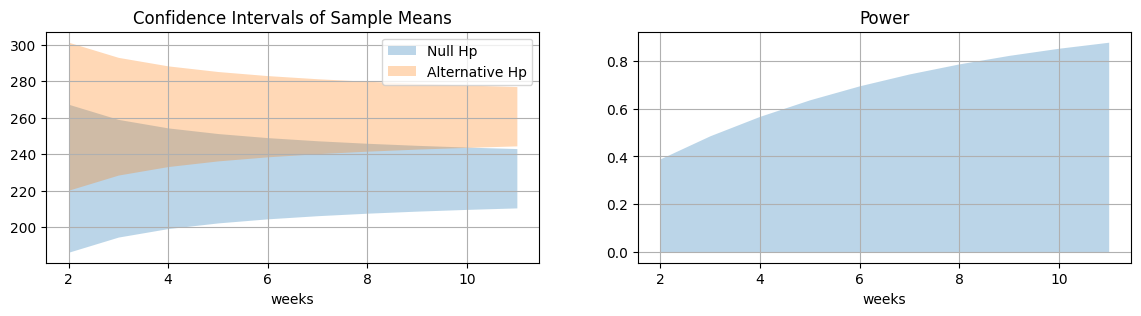

In [7]:
fig = plt.figure(figsize=(14.,3.))
Ax = fig.subplots(1,2,squeeze=False)

ax = Ax[0,0]
ax.set_title("Confidence Intervals of Sample Means")
ax.fill_between(
    dci["n_weeks"], dci["ci_low_sample_null"], dci["ci_high_sample_null"], 
    **fmt_ci, **fmt_null,
    label = "Null Hp"
    )
ax.fill_between(
    dci["n_weeks"], dci["ci_low_sample_alter"], dci["ci_high_sample_alter"], 
    **fmt_ci, **fmt_alter,
    label = "Alternative Hp"
    )
ax.set_xlabel("weeks")
ax.legend()
ax.grid()

ax = Ax[0,1]
ax.set_title("Power")
ax.fill_between( dci["n_weeks"], dci["power"], **fmt_ci, **fmt_null,)
ax.set_xlabel("weeks")
ax.grid()


The plot on the left shows the confidence interval on $\tilde\mu_o$ and $\tilde\mu_a$ (mean under the null and alternative hypothesis with a delta as per `difference_percent`) after x weeks from the campaign start. As you can see, these overlap a lot in the first weeks of campaign, meaning that, if we generated samples from the two distributions, it would be unlikely we spot any significant difference. This corresponds to a low power on the plot on the right. As the campaign length increases, the confidence intervals narrow down, the separation between the two becomes clear and the power increases.

> **Interpretation** Assuming that the campaign was successful, and we'd have an increase in daily sessions of `difference_percent`, we'd need to wait for at least 8-9 weeks in order to have a large enough power (>80%).

## 2. Fixed campaign length: MDE vs Power tradeoff.

In this example we assume the campaign length is fixed and we explore the trade-off between `power` and detectable effect (`difference_percent`).

In [8]:
# PARAMETERS
confidence_level = 0.90
alternative = "larger"
n_weeks = 6
data = []
# We assume we have daily data.
for difference_percent in range(1,30):
    data.append(
        {"n_weeks": n_weeks} | 
        causalinf.ab.t_test.get_test_design_summary( 
            mean_treated_unit, std_treated_unit, alternative=alternative, 
            n_obs=7*n_weeks, alpha=1.-confidence_level, difference_percent=difference_percent)
    )
dci = pd.DataFrame(data)
dci.head()

,n_weeks,power,n_obs,alpha,difference_percent,confidence_level,ci_low_sample_null,ci_high_sample_null,ci_low_sample_alter,ci_high_sample_alter
0,6,0.122609,42,0.1,1,0.9,204.587358,249.126928,206.855929,251.395500
1,6,0.148581,42,0.1,2,0.9,204.587358,249.126928,209.124500,253.664071
2,6,0.177995,42,0.1,3,0.9,204.587358,249.126928,211.393072,255.932642
3,6,0.210835,42,0.1,4,0.9,204.587358,249.126928,213.661643,258.201214
4,6,0.246981,42,0.1,5,0.9,204.587358,249.126928,215.930215,260.469785


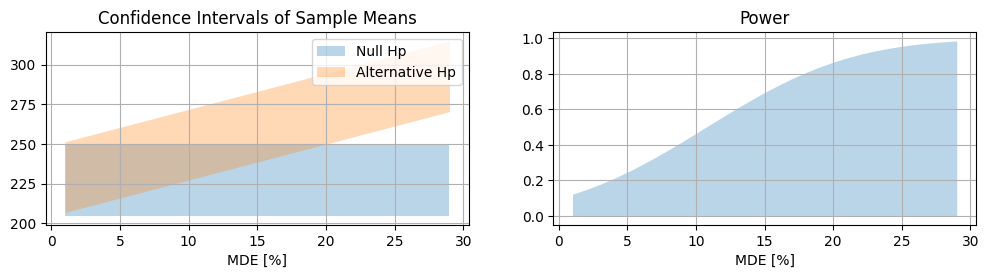

In [9]:
fig = plt.figure(figsize=(12.,2.5))
Ax = fig.subplots(1,2,squeeze=False)

ax = Ax[0,0]
ax.set_title("Confidence Intervals of Sample Means")
ax.fill_between(
    dci["difference_percent"], dci["ci_low_sample_null"], dci["ci_high_sample_null"], 
    **fmt_ci, **fmt_null,
    label = "Null Hp"
    )
ax.fill_between(
    dci["difference_percent"], dci["ci_low_sample_alter"], dci["ci_high_sample_alter"], 
    **fmt_ci, **fmt_alter,
    label = "Alternative Hp"
    )
ax.set_xlabel("MDE [%]")
ax.legend()
ax.grid()

ax = Ax[0,1]
ax.set_title("Power")
ax.fill_between( dci["difference_percent"], dci["power"], **fmt_ci, **fmt_null,)
ax.set_xlabel("MDE [%]")
ax.grid()


As per other parametric studies we notice that as the confidence intervals of the null and alternative hypothesis move apart, the power of the test increases.

> If we chose to run a campaign for 6 weeks, we'd be able to observe a MDE above 10% with a `power` of about 50% (i.e. 50% chances to detect the effect). The `confidence_level` inficates our probability of detecting a true negative - i.e. of detecting that the campaign had no impact, should that be the case.

# Appendix: Power Analysis Validation

To validate the power analysis, we have implemented a numerical test. The test will compute the test power under a given scenario. It will then produce synthetic samples with average as per the null and alternative hypothesis, and run a t-test to compare them. This is repeated a number of times, so as to evaluate the True Positive (the t-test identifies a significant difference) and True Negative (the test identifies there was no chance) rates which should match closely the test Power and confidence level, respectively.

In [10]:
os.environ.get("SRC_FOLDER")

'/home/user/libs/dst-python-causal-inference'

In [11]:

sys.path.append(os.path.join( os.environ.get("SRC_FOLDER"), "tests"))
from test_stats import test_power 

params_variable = [
    {"difference_percent": 15, "alternative": "two-sided"},
    {"difference_percent": -15, "alternative": "smaller"},
    {"difference_percent": 15, "alternative": "larger"},
]
for p in params_variable:
    test_power(
        mean_null_hp = 30.0, 
        unit_std = 5.0,
        confidence_level = 0.95,
        n_obs = 28,
        print_output = True,
        n_repetitions = 1000,
        **p) 


Mean under H0: 30.0
Mean under H1: 34.5
Test alternative is: two-sided
Test Power: 90.34%
Test Confidence Level: 95.00%
Numerical Simulation
TP: 90.8% of times we correctly detected an impact
FP: 4.1% of times we WRONGLY detected an impact
TN: 95.9% of times we correctly detected that there was NO impact
FN: 9.2% of times we WRONGLY detected that there was NO impact

Mean under H0: 30.0
Mean under H1: 25.5
Test alternative is: smaller
Test Power: 94.88%
Test Confidence Level: 95.00%
Numerical Simulation
TP: 94.5% of times we correctly detected an impact
FP: 5.1% of times we WRONGLY detected an impact
TN: 94.9% of times we correctly detected that there was NO impact
FN: 5.5% of times we WRONGLY detected that there was NO impact

Mean under H0: 30.0
Mean under H1: 34.5
Test alternative is: larger
Test Power: 94.88%
Test Confidence Level: 95.00%
Numerical Simulation
TP: 95.7% of times we correctly detected an impact
FP: 4.9% of times we WRONGLY detected an impact
TN: 95.1% of times we co